In [1]:
import numpy as np
from astropy.table import Table
from zero_point import zpt
from astropy.io import fits
zpt.load_tables()
from scipy.stats import gaussian_kde
from multiprocessing import Pool
from numpy.lib.recfunctions import append_fields, drop_fields
import emcee
import matplotlib.pyplot as plt

In [2]:
# Loading data and adding zero-point parallax
data = fits.getdata('GaiaEDR3_query_parallax_data.fits')

gmag = data['phot_g_mean_mag']
nueffused = data['nu_eff_used_in_astrometry']
psc = data['pseudocolour']
sinbeta = np.sin(np.deg2rad(data['ecl_lat']))
soltype = data['astrometric_params_solved']

zpvals = zpt.get_zpt(gmag, nueffused, psc, sinbeta, soltype)
zpvals[np.isnan(zpvals)] = 0

/home/rybizki/anaconda3/lib/python3.7/site-packages/zero_point_brugalada-0.0.1-py3.7.egg/zero_point/zpt.py:208: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  UserWarning)
/home/rybizki/anaconda3/lib/python3.7/site-packages/zero_point_brugalada-0.0.1-py3.7.egg/zero_point/zpt.py:236: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  UserWarning)


In [3]:
# Creating prior
gedr3mockprior = fits.getdata('GeDR3mock_query_distance_prior.fits')
kernel = gaussian_kde(1/gedr3mockprior.parallax)
prior_xrange = np.linspace(0,0.5,5001)
prior_yvalues = kernel(prior_xrange)

/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


Text(0.5, 0, 'dist in kpc')

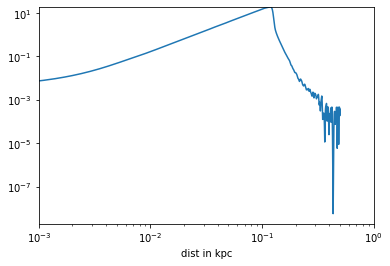

In [4]:
# Plot the prior distance distribution
plt.plot(prior_xrange,prior_yvalues)
plt.yscale('log')
plt.xscale('log')
plt.xlim((0.001,1))
plt.ylim((0,20))
plt.xlabel('dist in kpc')

In [5]:
# create the new distance catalogue structure
drop_list = []
for item in data.dtype.names:
    if item != 'source_id':
        drop_list.append(item)
cat_dist = drop_fields(data,drop_list, usemask=False, asrecarray=True)
names = []
arrays = []
array = np.zeros(shape=(len(data)))
for i in range(1,100):
    names.append("dist_%d" %(i))
    arrays.append(array)
names.append('mean_acceptance_fraction')
arrays.append(array)
names.append('mean_autocorrelation_time')
arrays.append(array)
cat_dist = append_fields(cat_dist,names,arrays,usemask=False, asrecarray=True)

In [6]:
# Functions needed for the inference:

def prior(r):
    '''
    the distance prior from the noisy parallax selection (gedr3mock)
    '''
    result = np.interp(r,prior_xrange,prior_yvalues,left = 0, right = 0)
    return(result)

def likelihood(pi,pe,r):
    '''
    distance likelihood for parallax measurement with corresponding uncertainty
    '''
    fac = np.divide(1,np.sqrt(2*pi*np.power(pe,2)))
    exp = np.exp(np.divide(-np.power(pi-np.divide(1,r),2),2*np.power(pe,2)))
    return(fac*exp)

# If we have a lot of negative parallaxes then the initialisation needs to work differently
def p0_guess(pi,nwalker):
    '''
    initialising distances for walkers
    '''
    dist = np.divide(1,pi)
    dists = np.random.normal(dist,0.01*dist,nwalker)
    for i in range(len(dists)):
        if dists[i] <= 0:
            dists[i] = np.divide(1,pi)
    return(dists.reshape(-1,1))

def log_post(dist,pi,pe):
    '''
    the log posterior for the mcmc sampler
    '''
    if dist <= 0:
        return(-np.inf)
    else:
        posterior = prior(dist) * likelihood(pi,pe,dist)
        return(np.log(posterior))

def sample_posterior(pi,pe):
    """
    Sampling the distance for one star
    """
    nwalkers = 4
    ndim = 1
    nburn = 350
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=[pi, pe])
    # initial starting position
    p0 = p0_guess(pi,nwalkers)
    # Burn in
    state = sampler.run_mcmc(p0, nburn)
    # actual run
    sampler.reset()
    # Here we need to tune the runtime. With 2500 most autocorrelation times will be estimated but it takes about 1s per source
    sampler.run_mcmc(state, 2500);
    samples = np.hstack(sampler.get_chain(flat=True))
    # thinning out
    samples = np.sort(samples)
    mean_af = np.mean(sampler.acceptance_fraction)
    try:
        mean_act = np.mean(sampler.get_autocorr_time())
    except:
        mean_act = np.nan
    return(samples,mean_af,mean_act)


In [7]:
# Check the runtime
i = [0]
pi = data.parallax[i] + zpvals[i]
pe = data.parallax_error[i]
%timeit samples,mean_af, mean_act = sample_posterior(pi,pe)

1.66 s ± 36.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# a wrapper such that the MCMC can run in parallel and the results are written out

number_of_processes = 8
# Sampling the posterior using emcee:
def wrapper_loop(i):
    print(i)
    pi = data.parallax[i]+ zpvals[i]
    pe = data.parallax_error[i]
    samples,mean_af, mean_act = sample_posterior(pi,pe)
    for j in range(1,100):
        cat_dist[i]["dist_%d" %j] = np.percentile(samples,j)
    cat_dist[i]['mean_acceptance_fraction'] = mean_af
    cat_dist[i]['mean_autocorrelation_time'] = mean_act
    #print(i,cat_dist[i]['dist_100'])
    return(cat_dist[i])    

pool = Pool(processes = number_of_processes)
result = pool.map(wrapper_loop, range(len(cat_dist)))

for j in range(len(cat_dist)):
    cat_dist[j] = result[j]
    
fits.writeto('dist_cat_edr3.fits', cat_dist)

026638

76152190228114





1
115
77
229
153
191
267
39
116
78
268
2
154230

192
40
3
117
155
79
269
231
193
41
4


/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


118
156
80
232
270
194
42
119
157
5
233
81
271
195
43
6
234
120
82
158
272
44
196


/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


7
235
83


/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


121
159
273
45


/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


197
8
236
84
274
160
122
46
198
9
237
275
85
123
161
47
276
10
199
238
124
86
48
162


/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


277
239
200
11
49
125
87
163
278
12240

201
50
88
126
164
279
241
202
13
89
51
127
165
280
242
14
203
52
128
90


/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


281
166
15
243
204
53
129
91
167
282
244
16
205
54
130
92
168
283
245


/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


1755

206
131
93
169
284
246
18
207
56
132
94
170
285
247
208
19
57
133
95
286
171
248
20
209
134
58
96
287
172
21
249
59
210
135
288
97
173
22
60
250
136211

98
289
174
61
23
251
137
212
99
290
175
24
62
252
138
213
291
100
176
63
25
253
139
214
101
292
177
26
64
140
254
215
102
293
178
65
255
141
27
216
103
294
179
66
142
256
28
217
104
295
180
67
143
257
29
218
105
296
181
68
30
144
258
219
106
182
297
69
31
145
259
220
107
183
70
298
32
146
260
221
108
184
71
299
33
147
261
222
109
185
300
72
34
262148

223
110
186
73
301
35
224
263
149
111
187
74
36
302
264
225
150
188
112
75
37
303
226
265
151
189
113
304
342
380
227
418
456
494
305
532
343
381
570
457
419
306
495
344
533
382
571
458
420
496
307
383
345
534
459
572
421
384
497
308
346
535
460
573
422
498
385
347
309
461
536
574
423
386348

310
499
537
462
575
424
387
349
311
500
463
538
576
425
388
312
350
577
464
501
539
426
389
313
351
578
465
502
540
427
390
352
579
314
466
503
541
428
391
353
580
315
504
467
542
392
429
581
3

/home/rybizki/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


927
965
1040
1116
1153
1078
1003
1191
966
928
1117
1041
1154
1079
1004
967
1192
929
1042
1155
1118
1080
1005
968
930
1119
1043
1156
1081
1006
969
931
1120
1157
1082
1044
1007
970
932
1121
1083
1158
1045
1008
971
933
1122
1084
1159
1046
1009
972
934
1123
1085
1160
1047
1010
973
935
1086
1124
1161
1048
1011
974
936
1087
1049
1125
1162
1012
975
937
1088
1126
1050
1163
1013
976
938
1089
1127
1051
1164
1014
939
977
1090
1128


/home/rybizki/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


1165
1052
1015
940
978
1091
1129
1166
1053
1016
941
979
1092
1130
1167
1054
1017
942
980
1093
1131
1168
1018
1055
943
981
1094
1132
1019
1169
1056
944
1095
982
1133
1170
1020
1057
945
1096
983
1134
1021
1171


/home/rybizki/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


1058
946
1097
984
1135
1172
1059
1022
947
1098
985
1136
1060
1173
1023
1099
948
986
1137
11741061

1024
949
1100
987
1138
1025
1175
1062
1101
1139
1176
1063
1177
